In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import os
import requests
import asyncio
import aiohttp
from typing import Annotated, List, Dict
from datetime import datetime
from io import StringIO
from xlsx2csv import Xlsx2csv
from bs4 import BeautifulSoup
import re
import json
from urllib.parse import quote_plus

from fund_flows import fund_flow_data_fetcher
from yahoofinance import download_historical_data_yahoofinance, multi_download_historical_data_yahoofinance

import nest_asyncio
nest_asyncio.apply()

%load_ext autoreload
%autoreload 2

In [2]:
current_directory = os.getcwd()
parent_dir = os.path.dirname(current_directory)

In [3]:
def read_excel_fast(
    path: str,
    sheet_name="Sheet1",
    cols_to_read: List[str] = None,
    chunk_size: int = None,
) -> pd.DataFrame:
    buffer = StringIO()
    Xlsx2csv(path, outputencoding="utf-8", sheetname=sheet_name).convert(buffer)
    buffer.seek(0)
    
    if cols_to_read is not None:
        usecols_options = lambda x: x in cols_to_read
    else:
        usecols_options = None

    if chunk_size:
        chunks = []
        for chunk in pd.read_csv(buffer, usecols=usecols_options, chunksize=chunk_size):
            chunks.append(chunk)
        df_read = pd.concat(chunks, ignore_index=True)
    else:
        df_read = pd.read_csv(buffer, usecols=usecols_options)

    return df_read

In [4]:
def fund_flow_plotter(
    fund_flow_df: pd.DataFrame = None,
    fund_flow_df_dict: Dict[str, pd.DataFrame] = None,
    yf_df_dict: Dict[str, pd.DataFrame] = None,
    weekly_range=False,
    monthly_range=False,
    date_subset_range: Annotated[List[datetime], 2] | None = None,
    ticker: str = None,
    tick_freq: int = None,
    verbose=False,
    plot_volume=False,
    plot_price=False,
):
    if fund_flow_df is not None and fund_flow_df_dict is None:
        fund_flow_df["asOf"] = pd.to_datetime(fund_flow_df["asOf"])
        if date_subset_range:
            fund_flow_df = fund_flow_df[
                (fund_flow_df["asOf"] > date_subset_range[0])
                & (fund_flow_df["asOf"] < date_subset_range[1])
            ]

        if weekly_range:
            fund_flow_df = fund_flow_df.resample("W", on="asOf").sum().reset_index()
        elif monthly_range:
            fund_flow_df = fund_flow_df.resample("M", on="asOf").sum().reset_index()

        if plot_volume or plot_price:
            if date_subset_range:
                from_date, to_date = date_subset_range[0], date_subset_range[1] 
            else:
                from_date, to_date = datetime(2000, 1, 1), datetime.today()
                
            volume_df = download_historical_data_yahoofinance(ticker=ticker, from_date=from_date, to_date=to_date, raw_path=r"C:\Users\chris\fund_flows\yahoofinance")
            print(volume_df) if verbose else None
            volume_df["Date"] = pd.to_datetime(volume_df["Date"])
            if date_subset_range:
                volume_df = volume_df[
                    (volume_df["Date"] > date_subset_range[0])
                    & (volume_df["Date"] < date_subset_range[1])
                ]

            if weekly_range:
                volume_df = volume_df.resample("W", on="asOf").sum().reset_index()
            elif monthly_range:
                volume_df = volume_df.resample("M", on="asOf").sum().reset_index()
        
        dates = fund_flow_df["asOf"]
        latest_date_str = max(dates).strftime("%m-%d-%Y")
        print(f"Latest flow data for {ticker}: {latest_date_str}") if verbose else None
        if tick_freq is not None:
            mask = dates.index % tick_freq == 0
            selected_dates = dates[mask]
        else:
            selected_dates = fund_flow_df["asOf"]
            
        _, ax = plt.subplots(figsize=(17, 8))
        for _, row in fund_flow_df.iterrows():
            color = "green" if row["value"] > 0 else "red"
            y_start = 0
            dy = row["value"]

            ax.arrow(
                row["asOf"],
                y_start,
                0,
                dy,
                head_width=0.15,
                head_length=abs(dy) * 0.3,
                fc=color,
                ec=color,
            )
        
        title = "Fund Flows"
        if plot_volume:
            title += " & Volume"
        if plot_price:
            title += " & Adj Close"
        
        ax.set_title(f"{title} for {ticker}" if ticker else "Fund Flows")
        ax.set_xlabel("Date")
        ax.set_ylabel("($, M)")

        ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d-%Y"))
        ax.set_xticks(selected_dates)

        plt.xticks(rotation=45)
        plt.grid(visible=True, linestyle="--", linewidth=0.5)
        ax.axhline(0, color="black", linewidth=0.6)
        
        if plot_volume:
            ax2 = ax.twinx()
            ax2.bar(volume_df["Date"], volume_df["Volume"], width=2, alpha=0.5, color='royalblue', label='Volume')
            ax2.set_ylabel('Volume')
            ax2.legend(loc='upper left')
        
        if plot_price:
            ax3 = ax.twinx()
            ax3.spines.right.set_position(("axes", 1.05))
            ax3.plot(volume_df["Date"], volume_df["Adj Close"], color='purple', label='Adj Close', linewidth=2, alpha=0.35)
            ax3.set_ylabel('Adj Close', color='purple')
            ax3.tick_params(axis='y', labelcolor='purple')
            ax3.legend(loc='upper right')

        plt.tight_layout()
        plt.show()
    
    elif fund_flow_df is None and fund_flow_df_dict is not None:
        num_tickers = len(list(fund_flow_df_dict.keys()))
        _, axs = plt.subplots(num_tickers, 1, figsize=(17, 8 * num_tickers))
        axs: List[plt.Axes] = axs
        failed_to_plot = []

        for ax, ticker in zip(axs, list(fund_flow_df_dict.keys())):
            try:
                fund_flow_df = fund_flow_df_dict[ticker]
                fund_flow_df["asOf"] = pd.to_datetime(fund_flow_df["asOf"])

                if date_subset_range:
                    fund_flow_df = fund_flow_df[
                        (fund_flow_df["asOf"] > date_subset_range[0])
                        & (fund_flow_df["asOf"] < date_subset_range[1])
                    ]

                if weekly_range:
                    fund_flow_df = fund_flow_df.resample("W", on="asOf").sum().reset_index()
                elif monthly_range:
                    fund_flow_df = fund_flow_df.resample("M", on="asOf").sum().reset_index()
                
                volume_df = pd.DataFrame() 
                if plot_volume and yf_df_dict is not None:
                    if date_subset_range:
                        from_date, to_date = date_subset_range[0], date_subset_range[1] 
                    else:
                        from_date, to_date = datetime(2000, 1, 1), datetime.today()
                        
                    volume_df = yf_df_dict[ticker]
                    volume_df["Date"] = pd.to_datetime(volume_df["Date"])
                    if date_subset_range:
                        volume_df = volume_df[
                            (volume_df["Date"] > date_subset_range[0])
                            & (volume_df["Date"] < date_subset_range[1])
                        ]

                    if weekly_range:
                        volume_df = volume_df.resample("W", on="asOf").sum().reset_index()
                    elif monthly_range:
                        volume_df = volume_df.resample("M", on="asOf").sum().reset_index()

                dates = fund_flow_df["asOf"]
                latest_date_str = max(dates).strftime("%m-%d-%Y")
                print(f"Latest flow data for {ticker}: {latest_date_str}") if verbose else None
                if tick_freq is not None:
                    mask = dates.index % tick_freq == 0
                    selected_dates = dates[mask]
                else:
                    selected_dates = fund_flow_df["asOf"]

                for _, row in fund_flow_df.iterrows():
                    color = "green" if row["value"] > 0 else "red"
                    y_start = 0
                    dy = row["value"]

                    ax.arrow(
                        row["asOf"],
                        y_start,
                        0,
                        dy,
                        head_width=0.15,
                        head_length=abs(dy) * 0.3,
                        fc=color,
                        ec=color,
                    )
                    
                if plot_volume:
                    ax.set_title(f"Fund Flows & Volume for {ticker}" if ticker else "Fund Flows")
                else:
                    ax.set_title(f"Fund Flows for {ticker}" if ticker else "Fund Flows")

                ax.set_title(f"Fund Flow for {ticker}")
                ax.set_xlabel("Date")
                ax.set_ylabel("($, M)")

                ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d-%Y"))
                ax.set_xticks(selected_dates)

                ax.tick_params(axis="x", rotation=45)
                ax.grid(visible=True, linestyle="--", linewidth=0.5)
                ax.axhline(0, color="black", linewidth=0.6)
                
                if plot_volume:
                    ax2 = ax.twinx()
                    ax2.bar(volume_df["Date"], volume_df["Volume"], width=1, alpha=0.4, color='royalblue', label='Volume')
                    ax2.set_ylabel('Volume')
                    ax2.legend(loc='upper left')
                    
                if plot_price:
                    ax3 = ax.twinx()
                    ax3.spines.right.set_position(("axes", 1.05))
                    ax3.plot(volume_df["Date"], volume_df["Adj Close"], color='purple', label='Adj Close', linewidth=2, alpha=0.35)
                    ax3.set_ylabel('Adj Close', color='purple')
                    ax3.tick_params(axis='y', labelcolor='purple')
                    ax3.legend(loc='upper right')
            except Exception as e:
                print(ticker, e) if verbose else None
                failed_to_plot.append(ticker)
                continue
        
        print(f"Failed to plot: {failed_to_plot}") if len(failed_to_plot) > 0 else None
        plt.tight_layout()
        plt.show()

    else:
        print("Womp womp")

In [5]:
def plot_flows(
    tickers: List[str] | str,
    weekly_range=False,
    monthly_range=False,
    date_subset_range: Annotated[List[datetime], 2] | None = None,
    tick_freq: int = None,
    update=False,
    fetch_date_from: datetime = datetime(2000, 1, 1),
    fetch_date_to: datetime = datetime.today(),
    plot_volume=False,
    plot_price=False,
    verbose=False,
):
    if isinstance(tickers, str):
        tickers = [tickers]

    fund_flow_df_dict = {}
    yahoofinance_df_dict = {}
    if not update:
        need_to_fetch_tickers_flows = []
        need_to_fetch_tickers_yf = []
        for ticker in tickers:
            try:
                fund_flow_df = read_excel_fast(
                    os.path.join(
                        parent_dir, f"fund_flows/flows/{ticker}_fund_flow_data.xlsx"
                    )
                )
                fund_flow_df_dict[ticker] = fund_flow_df
            except:
                (
                    print(
                        f"No Excel File Found for {ticker}: Fetching Fund Flows Data..."
                    )
                    if verbose
                    else None
                )
                need_to_fetch_tickers_flows.append(ticker)

            try:
                yf_df = read_excel_fast(
                    os.path.join(
                        parent_dir,
                        f"fund_flows/yahoofinance/{ticker}_yahoofin_historical_data.xlsx",
                    )
                )
                yahoofinance_df_dict[ticker] = yf_df
            except:
                (
                    print(f"No Excel File Found for {ticker}: Fetching YF Data...")
                    if verbose
                    else None
                )
                need_to_fetch_tickers_yf.append(ticker)

        if len(need_to_fetch_tickers_flows) > 0:
            fetched_flows_df_dict = fund_flow_data_fetcher(
                need_to_fetch_tickers_flows,
                date_from=fetch_date_from,
                date_to=fetch_date_to,
            )
            fund_flow_df_dict.update(fetched_flows_df_dict)

        if len(need_to_fetch_tickers_yf) > 0:
            fetched_yf_df_dict = multi_download_historical_data_yahoofinance(
                need_to_fetch_tickers_yf,
                from_date=fetch_date_from,
                to_date=fetch_date_to,
                raw_path=os.path.join(parent_dir, f"fund_flows/yahoofinance"),
                max_date=True,
                write_to_xlsx=False,
            )
            yahoofinance_df_dict.update(fetched_yf_df_dict)

    else:
        print(f"Fetching fund flows for {tickers}") if verbose else None
        fund_flow_df_dict = fund_flow_data_fetcher(
            tickers, date_from=fetch_date_from, date_to=fetch_date_to
        )
        print(fund_flow_df_dict) if verbose else None

        print(f"Fetching yf for {tickers}") if verbose else None
        yahoofinance_df_dict = multi_download_historical_data_yahoofinance(
            tickers=tickers,
            from_date=fetch_date_from,
            to_date=fetch_date_to,
            raw_path=os.path.join(parent_dir, f"fund_flows/yahoofinance"),
            max_date=True,
            write_to_xlsx=False,
        )
        print(yahoofinance_df_dict) if verbose else None

    if len(tickers) == 1:
        return fund_flow_plotter(
            fund_flow_df=fund_flow_df_dict[tickers[0]],
            ticker=tickers[0],
            yf_df_dict=yahoofinance_df_dict,
            weekly_range=weekly_range,
            monthly_range=monthly_range,
            date_subset_range=date_subset_range,
            tick_freq=tick_freq,
            verbose=verbose,
            plot_volume=plot_volume,
            plot_price=plot_price
        )

    return fund_flow_plotter(
        fund_flow_df_dict=fund_flow_df_dict,
        yf_df_dict=yahoofinance_df_dict,
        weekly_range=weekly_range,
        monthly_range=monthly_range,
        date_subset_range=date_subset_range,
        tick_freq=tick_freq,
        verbose=verbose,
        plot_volume=plot_volume,
        plot_price=plot_price
    )

In [6]:
headers = {
    "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7",
    "Accept-Encoding": "gzip, deflate, br",
    "Accept-Language": "en-US,en;q=0.9",
    "Cache-Control": "max-age=0",
    "Connection": "keep-alive",
    "Dnt": "1",
    "Host": "etfdb.com",
    "Referer": "https://www.google.com/",
    "Sec-Ch-Ua": '"Not A(Brand";v="99", "Google Chrome";v="121", "Chromium";v="121"',
    "Sec-Ch-Ua-Mobile": "?0",
    "Sec-Ch-Ua-Platform": '"Windows"',
    "Sec-Fetch-Dest": "document",
    "Sec-Fetch-Mode": "navigate",
    "Sec-Fetch-Site": "same-origin",
    "Sec-Fetch-User": "?1",
    "Upgrade-Insecure-Requests": "1",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/121.0.0.0 Safari/537.36",
}


def get_vetta_page_id(url: str):
    res = requests.get(url, headers=headers)
    if res.status_code != 200:
        raise Exception(f"Bad Status: {res.status_code}")
    soup = BeautifulSoup(res.text, "html.parser")
    tags_with_ad_slot = []
    page_ids = set()
    if "/etfs/sector/" in url:
        pattern = re.compile(r"ad-slot-\d{4}-")
    else:
        pattern = re.compile(r"ad-slot-\d{3}-")
    for div in soup.find_all("div"):
        for _, value in div.attrs.items():
            if pattern.search(str(value)) and "data-dfp-unit" in div.attrs:
                tags_with_ad_slot.append(div["data-dfp-unit"])
                try:
                    tag = str(div["data-dfp-unit"])
                    page_ids.add(tag.split("-")[2])
                except:
                    pass
                break

    return page_ids


def generate_page_urls(
    url: str, pages: int, is_api_link: bool, custom_pages: List[int] = None,
):
    base_urls = []
    if is_api_link:
        for i in range(0, pages * 25, 25):
            base_url = url[:-1]
            base_urls.append(base_url + str(i))
    else:
        page_id = get_vetta_page_id(url).pop()
        base_opts = json.dumps({"by_type": ["Etfdb::EtfType", page_id, None, False, False]})
        base_opts_encoded = quote_plus(base_opts)
        if "/asset-class/" in url:
            for i in range(1, pages):
                base_url = url[:-1]
                base_urls.append(base_url + str(i))
        elif custom_pages:
            for pages in custom_pages:
                base_url = f"https://etfdb.com/data_set/?tm=77522&cond={base_opts_encoded}&no_null_sort=true&count_by_id=&limit=25&sort=assets_under_management&order=desc&limit=25&offset={(pages-1)*25}"
                base_urls.append(base_url)
        else:
            for i in range(0, pages * 25, 25):
                base_url = f"https://etfdb.com/data_set/?tm=77522&cond={base_opts_encoded}&no_null_sort=true&count_by_id=&limit=25&sort=assets_under_management&order=desc&limit=25&offset={i}"
                base_urls.append(base_url)

    return base_urls


def get_tickers_from_vetta(
    url: str, pages: int = None, custom_pages: List[int] = None, is_api_link=False
):
    if not pages and not custom_pages:
        res = requests.get(url, headers=headers)
        if res.status_code != 200:
            raise Exception(f"Bad Status: {res.status_code}")
        soup = BeautifulSoup(res.text, "html.parser")

        if "/country/" in url:
            return [
                row.find("td").find("a").text
                for row in soup.findAll("table")[0].tbody.findAll("tr")
            ]

        return [
            row.find("td").find("a").text
            for row in soup.findAll("table")[1].tbody.findAll("tr")
        ]

    async def fetch(session: aiohttp.ClientSession, curr_url: str):
        try:
            async with session.get(curr_url) as response:
                if response.status != 200:
                    raise Exception(f"Bad Status: {response.status}")
                if "/asset-class/" in url:
                    text = await response.text()
                    soup = BeautifulSoup(text, "html.parser")
                    table = soup.find("table")
                    table_data = []
                    headers = []
                    for header in table.find_all("th"):
                        headers.append(header.text.strip())

                    if not headers:
                        headers = [
                            "Column {}".format(i)
                            for i, _ in enumerate(
                                table.find("tr").find_all("td"), start=1
                            )
                        ]

                    for row in table.find("tbody").find_all("tr"):
                        row_data = []
                        for td in row.find_all("td"):
                            row_data.append(td.text.strip())
                        table_data.append(row_data)

                    cleaned_headers = [header.split("\n\n\n")[0] for header in headers]
                    df = pd.DataFrame(table_data, columns=cleaned_headers)
                    return df["Symbol"].values.tolist()
                else:
                    json = await response.json()
                    tickers = []
                    for row in json.get("rows", []):
                        symbol_html = row.get("symbol")
                        if symbol_html:
                            match = re.search(
                                r"class=\"caps\">(.*?)</span>", symbol_html
                            )
                            if match:
                                tickers.append(match.group(1))
                    return tickers
        except Exception as e:
            print(e)
            return []

    async def get_promises(session: aiohttp.ClientSession):
        urls = generate_page_urls(url, pages, is_api_link, custom_pages)
        return await asyncio.gather(*[fetch(session, url) for url in urls])

    async def run_fetch_all() -> List[Dict[str, str]]:
        async with aiohttp.ClientSession(headers=headers) as session:
            all_data = await get_promises(session)
            return all_data

    results = asyncio.run(run_fetch_all())
    tickers = [x for xs in results for x in xs]
    return list(set(tickers))


def get_tickers_from_vetta_to_df(url: str):
    res = requests.get(url)
    if res.status_code != 200:
        raise Exception(f"Bad Status: {res.status_code}")

    soup = BeautifulSoup(res.text, "html.parser")
    table = soup.find("table")
    table_data = []
    headers = []
    for header in table.find_all("th"):
        headers.append(header.text.strip())

    if not headers:
        headers = [
            "Column {}".format(i)
            for i, _ in enumerate(table.find("tr").find_all("td"), start=1)
        ]

    for row in table.find("tbody").find_all("tr"):
        row_data = []
        for td in row.find_all("td"):
            row_data.append(td.text.strip())
        table_data.append(row_data)

    cleaned_headers = [header.split("\n\n\n")[0] for header in headers]
    df = pd.DataFrame(table_data, columns=cleaned_headers)
    df = df.dropna()
    df.to_excel("temp.xlsx")
    return df

In [80]:
bond_etf_tickers = get_tickers_from_vetta(url=r"https://etfdb.com/data_set/?tm=94666&cond={%22by_type%22:[%22Etfdb::EtfType%22,374,null,false,false]}&no_null_sort=true&count_by_id=&limit=25&sort=assets_under_management&order=desc&limit=25&offset=0", pages=3, is_api_link=True)

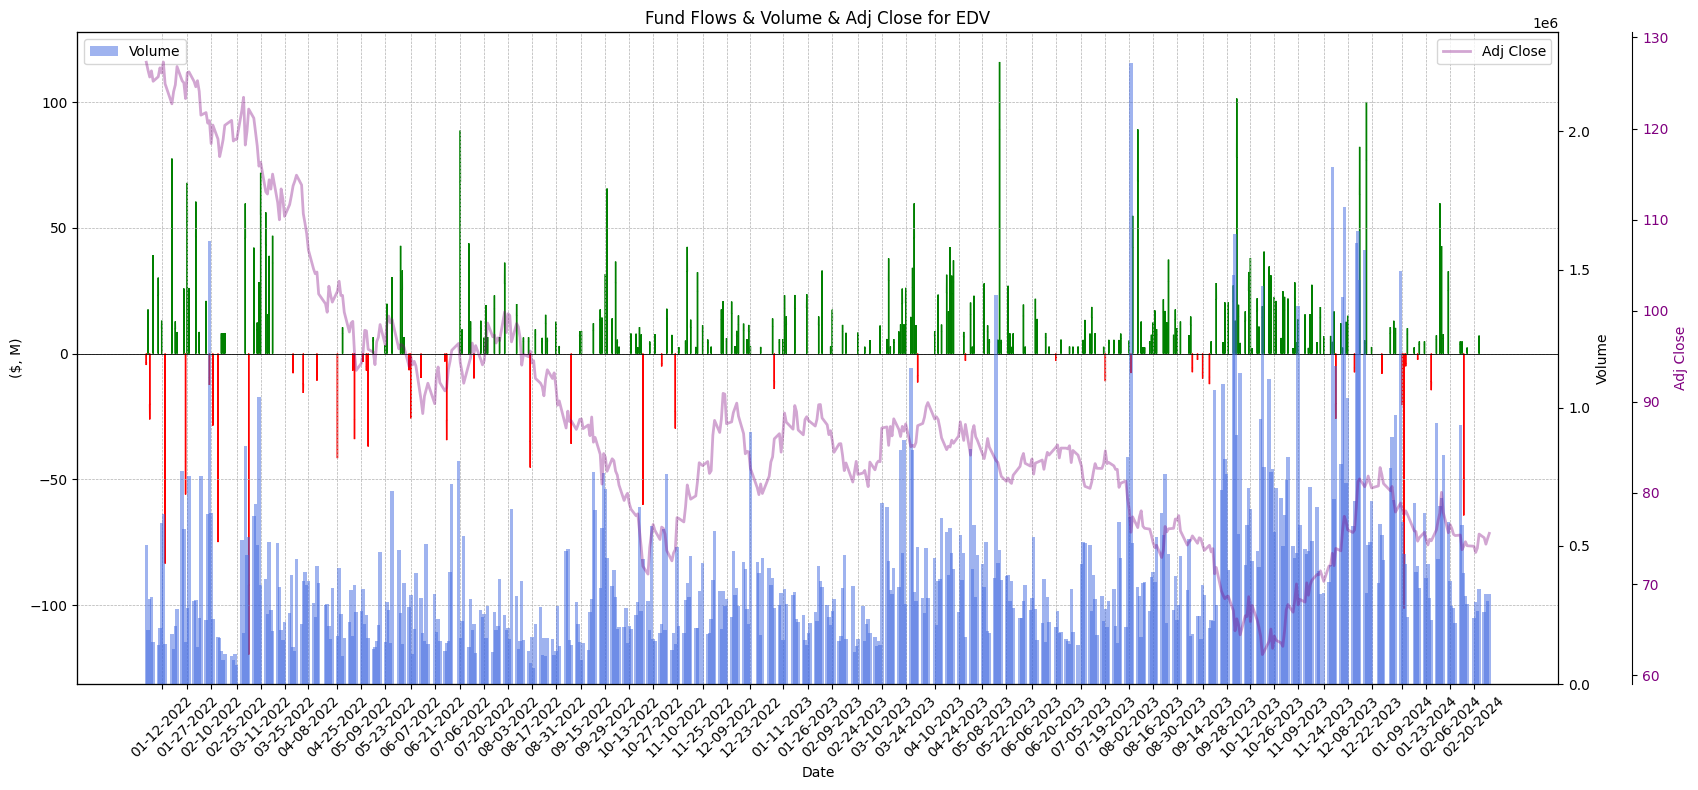

In [7]:
plot_flows(tickers=["EDV"], date_subset_range=[datetime(2022, 1, 1), datetime.today()], tick_freq=10, update=False, plot_volume=True, plot_price=True)